# Phase1: Demand Generator

In [ ]:
import sys, os
from datetime import datetime, timedelta
sys.path.append(os.path.abspath('../lib/demand'))
import pandas as pd
import numpy as np
import importlib
import Environment as env_mod


# simulator class
importlib.reload(env_mod)
SimulationConfig = env_mod.SimulationConfig
Simulator = env_mod.Simulator

In [ ]:
#- parameter setting -#
# Setting of Demand Generator 
start_time = datetime(2024, 12, 31)     # the start time of demand generation 
end_time = datetime(2027, 12, 31)       # the end time of demand generation
delta_time = 1                          # the interval between two time points
seed = 3                                # random seed number

# Dealer, Truck and Part
n_dealers = 2               # the number of dealers
n_truck_range = [5, 10]     # the range of truck fleet sizes in each dealer 
n_part_range = [5, 7]      # the range of the number of parts constituting truck



In [ ]:
#- demand simulation -#
# class: Simulator Configuration
cfg = SimulationConfig(
    start_time = start_time,
    end_time = end_time,
    delta_time = delta_time
)

# class: Simulator
sim = Simulator(
    config=cfg, 
    seed=seed, 
    n_dealers=n_dealers,
    n_truck_range=n_truck_range,
    n_part_range=n_part_range)
events = sim.run()


# Phase2: Forecasting

In [ ]:
#- library import -#
import forecast as forecast_md
importlib.reload(forecast_md)
ForecastMK = forecast_md.ForecastMaker

#- parameter setting -#
start_date = '2025-01-01'
train_days = 365*2
ML_model = ["XGBoost", "SVR", "RandomForest"]
TSA_model = ["ARIMA"]
forecast_model_list = ML_model + TSA_model      # forecasting model (available): XGBoost, RandomForest, SVR, ARIMA
feature_type_list = ["basic", "historical"]     # basic: basic features, historical: basic + historical features

#- training/forecast -#
ForecastMK = ForecastMK(forecast_model_list, feature_type_list, start_date, train_days)
ForecastMK.mk_forecast_model()

# Phase3: Cost Simulation

In [ ]:
sys.path.append(os.path.abspath('../lib/cost'))
# Preprocessor
import Preprocessor as prepro_md
importlib.reload(prepro_md)
Preprocessor = prepro_md.Preprocessor

# simulationLogic
import simulationLogic as sim_md
importlib.reload(sim_md)
SimulationConfig = sim_md.SimulationConfig
IntegratedSimulator = sim_md.IntegratedSimulator

# inventory polices
import inventoryPolices as invpol_md
importlib.reload(invpol_md)
StandardInventoryPolicy = invpol_md.StandardInventoryPolicy
InventoryPolicyParams = invpol_md.InventoryPolicyParams
PredictiveIntervalPolicy = invpol_md.PredictiveIntervalPolicy
PredictiveInventoryPolicyParams = invpol_md.PredictiveInventoryPolicyParams

# plot metrics
import plotMetrics as plotmet_md
importlib.reload(plotmet_md)
MetricsPlotter = plotmet_md.MetricsPlotter

# read demand data
import DemandDataArrangement as dda_md
importlib.reload(dda_md)
DemandDataArrange = dda_md.DemandDataArrange

In [ ]:
#- policy parameters -#
lead_time = 14          # the period between placing an order and the arrival of the part
service_level = 0.95    # the desired fill rate: 
initial_stock = 80      # the initial amount of each part in inventory
review_period = 1       # the frequency of checking the stock level

#- policy configuration -#
policy_params = InventoryPolicyParams(
    lead_time=lead_time,
    service_level=service_level,    
    review_period=review_period   
)

#- inventory management policy -#
policy = StandardInventoryPolicy(policy_params)

#- inventory management (cost simulation) -#
for model in forecast_model_list:
    # demand data
    dda = DemandDataArrange(model=model)

    for feature_type in feature_type_list:
        # load part and dealer information
        if model in ML_model:
            dda.load_all_part_dealer_information(feature_type)
        else:
            dda.load_all_part_dealer_information_for_TSA()

        # kpi results
        kpi_results = pd.DataFrame(columns=["dealer_id",
                                        "part_type",
                                        "total_costs",
                                        "ISL",
                                        "total_stockouts",
                                        "total_demand",
                                        "immediate_fulfilled",
                                        "backorder_fulfileed"])
        
        # inventory management for each part
        for i in range(dda.n_parts):
            # dealer - part
            dealer = dda.dealer_part_list[0][i]
            part = dda.dealer_part_list[1][i]

            # load demand data
            if model in ML_model:
                start_time, actual_demand, forecasted_demand = dda.load_single_demand_series(feature_type,dealer,part)
            else:
                start_time, actual_demand, forecasted_demand = dda.load_single_demand_series_for_TSA(dealer,part)
            start_time = datetime.strptime(start_time, "%Y-%m-%d")

            #- simulation setting -#
            forecast_config = SimulationConfig(
                start_time=start_time,              # begining time
                forecast_demand=forecasted_demand,  # forecasted demand (forecasting data)
                actual_demand=actual_demand,        # actual demand (answer data)
                inventory_policy=policy,            # inventory management policy
                initial_stock=initial_stock         # initial amount of existing parts available in the inventory
            )

            #- simulation -#
            forecast_simulator = IntegratedSimulator(forecast_config)
            res_forecast = forecast_simulator.run()
            kpi_results.loc[len(kpi_results)] = [
                dealer,
                part,
                res_forecast['kpis']['total_costs'],
                res_forecast['kpis']['immediate_service_level'],
                res_forecast['kpis']['total_stockouts'],
                res_forecast['kpis']['total_demand'],
                res_forecast['kpis']['immediate_fulfilled'],
                res_forecast['kpis']['backorder_fulfilled']
            ]

            #- simulation config -#
            config = SimulationConfig(
                start_time=start_time,
                forecast_demand=actual_demand, 
                actual_demand=actual_demand,
                inventory_policy=policy,
                initial_stock=initial_stock
            )

            #- simulation -#
            simulator = IntegratedSimulator(config)
            res_actual = simulator.run()        

        # record
        if model in ML_model:
            dda.write_kpis_results(kpi_results)
            # print(kpi_results)

            dda.summrize_results()
            dda.corrcoef_results()
        else:
            dda.write_kpis_results_for_TSA(kpi_results)
            # print(kpi_results)

            dda.summrize_results_for_TSA()
            dda.corrcoef_results_for_TSA()


# Output

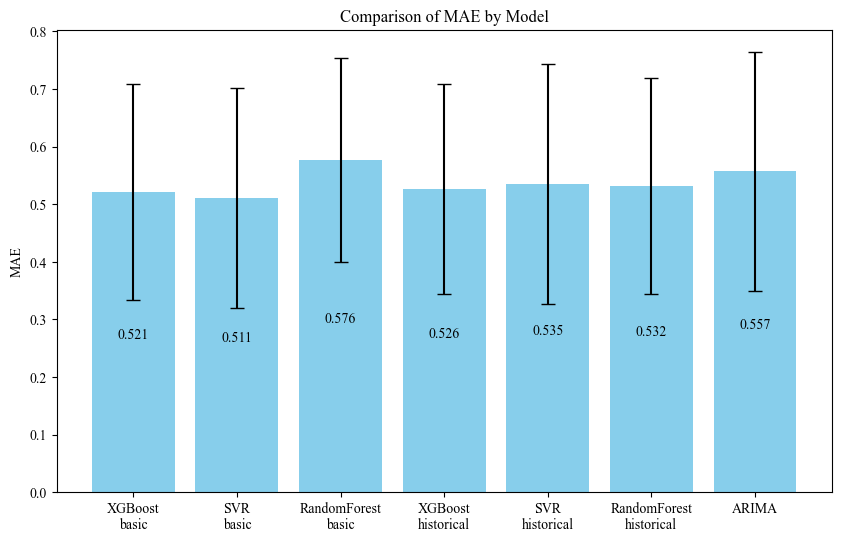

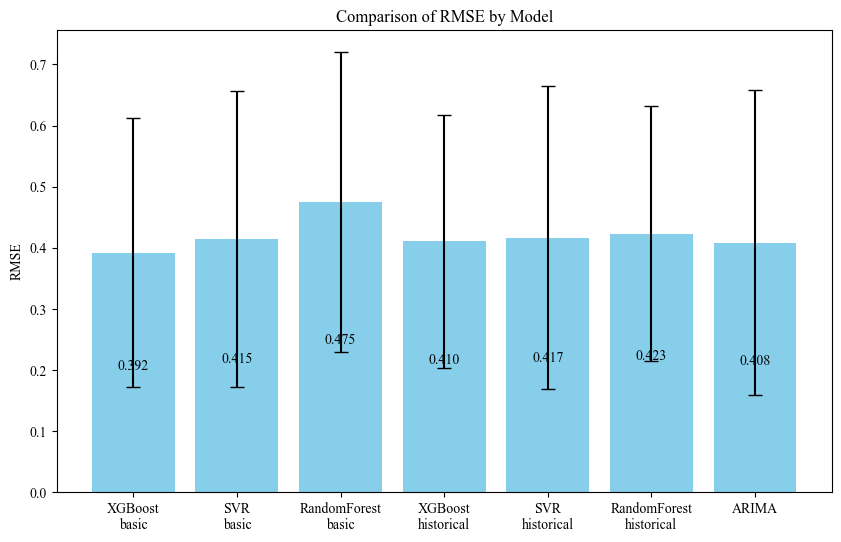

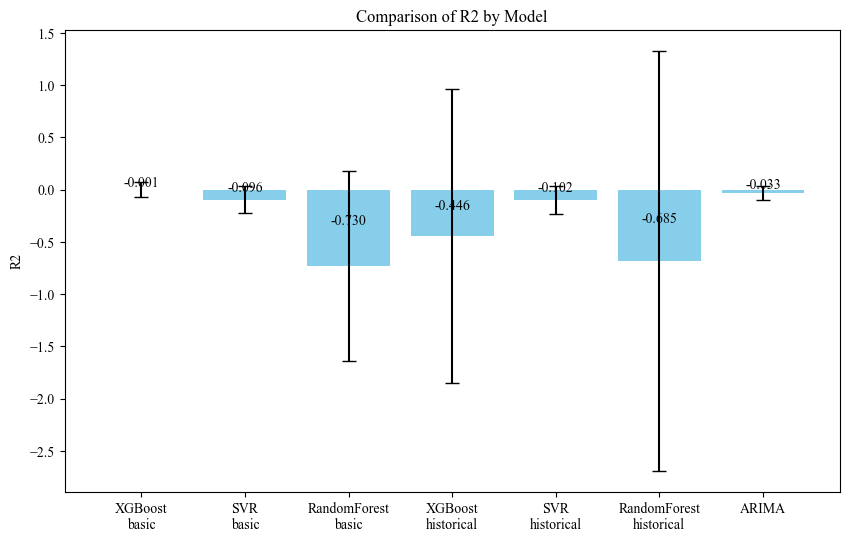

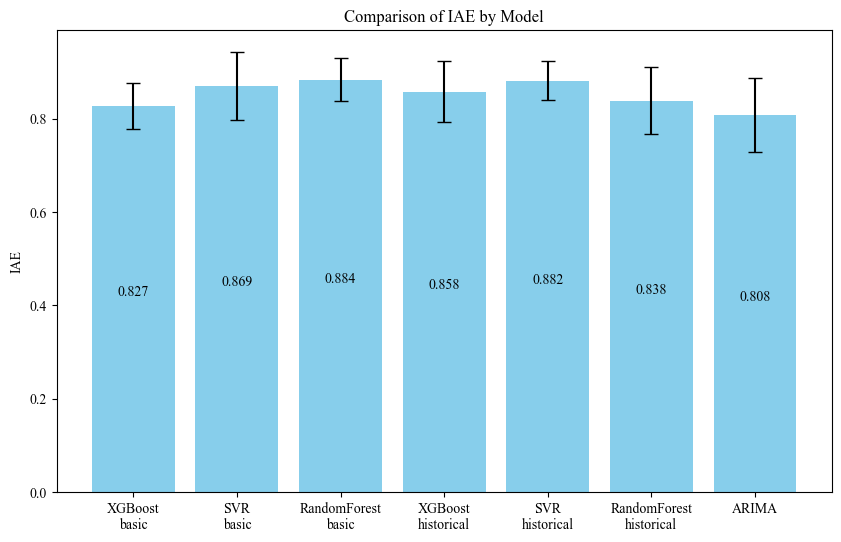

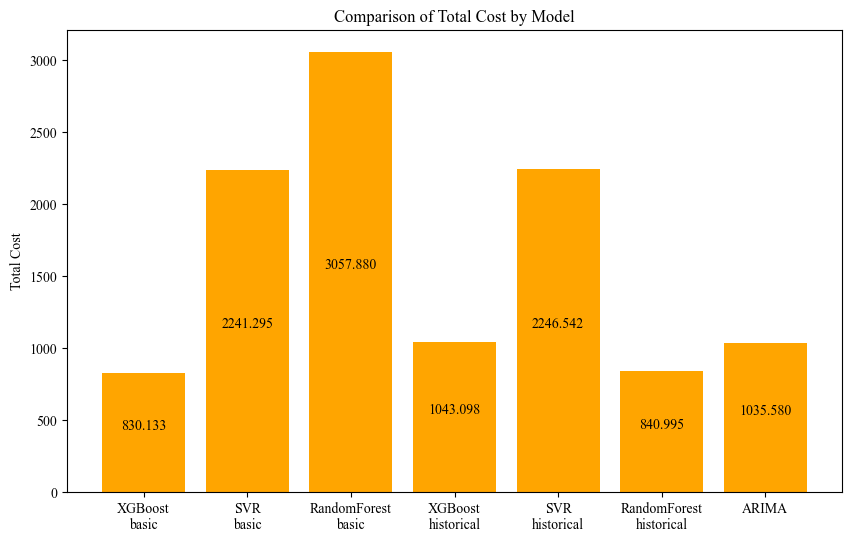

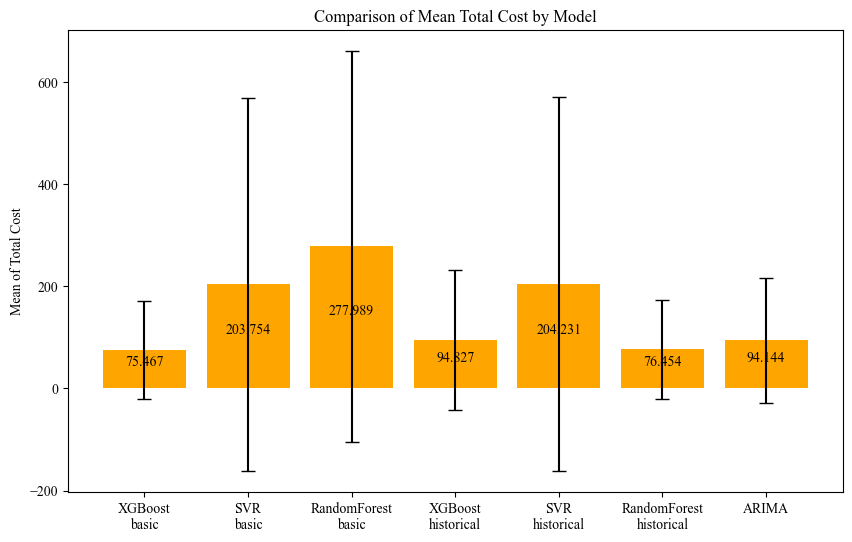

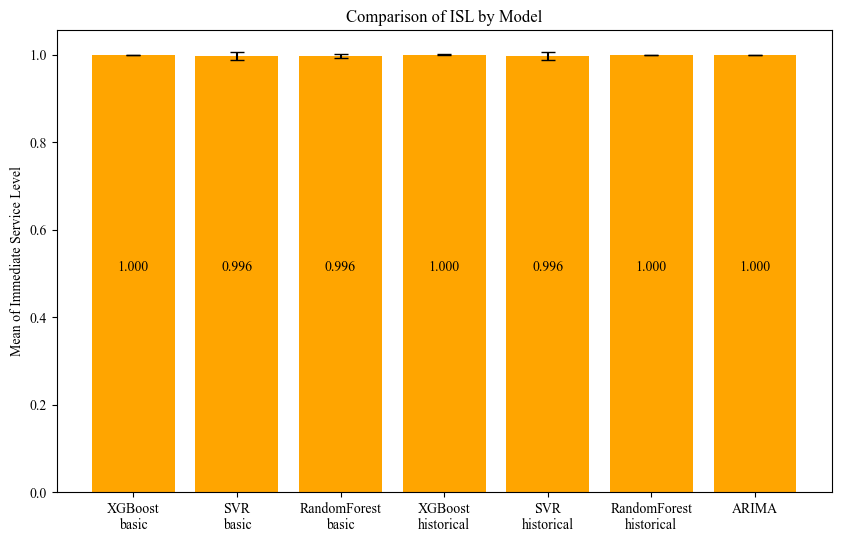

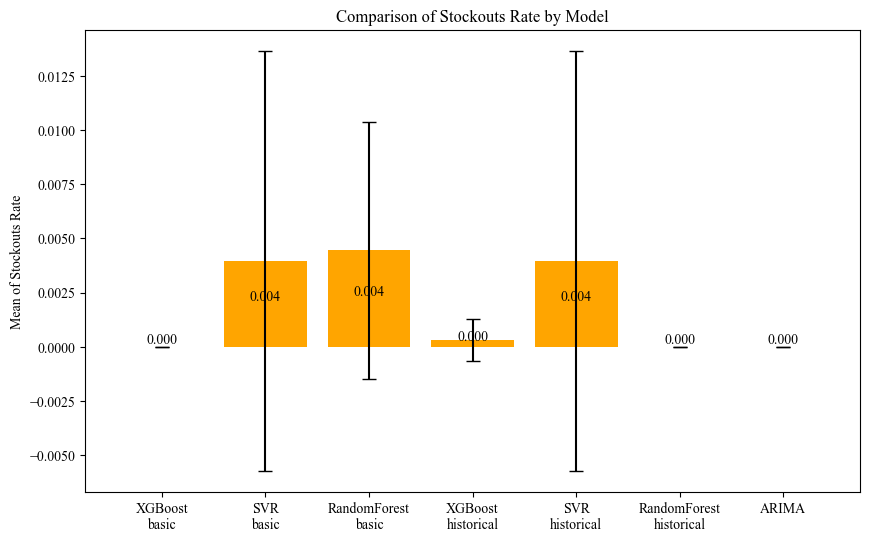

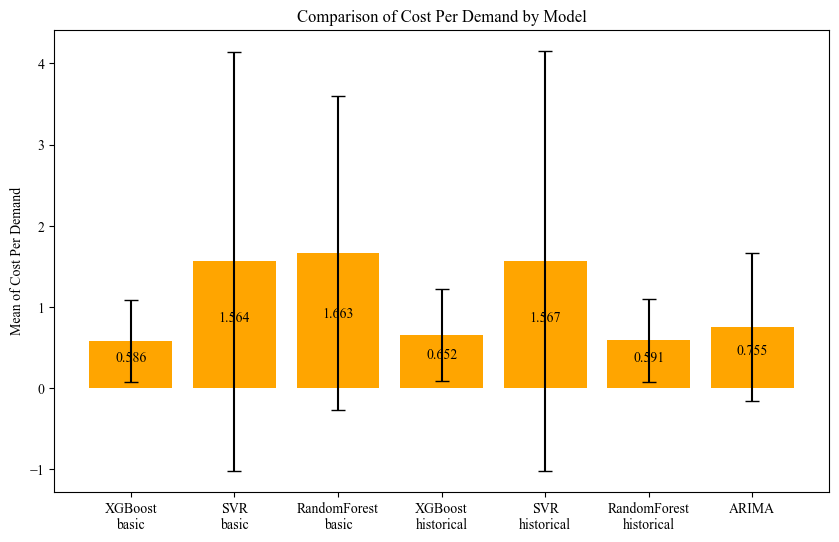

In [ ]:
sys.path.append(os.path.abspath('../lib'))

# ResultComparison class
import importlib
import ResultComparison as comp_mod
importlib.reload(comp_mod)
ResultComparison = comp_mod.ResultComparison

# Prediction Accuracy / KPIs
rscmp = ResultComparison()
noise_list = []
rscmp.visual_multiple_feature_results(feature_type_list, 
                                      ML_model, 
                                      TSA_model, 
                                      noise_list)